In [1]:
from LocalDatabase import get_schedule_connection
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [15]:
conn = get_schedule_connection()
sql = "select begin_at, count(*) c from student_appointments sa join schedules s on sa.schedule_id = s.id \
    and s.begin_at > '2018-06-01 00:00:00' where sa.status in (3,4) group by begin_at having count(*) > 100"
sql =  "select date_format(begin_at, '%%x-%%v') begin , sum(student_count) from schedules s join rooms r \
on s.id = r.schedule_id and r.status = 1 and r.klass_id is null \
where begin_at > %r group by date_format(begin_at, '%%x-%%v') " % '2018-06-01'
df = pd.read_sql(sql, conn, index_col='begin')

In [17]:
df

,sum(student_count)
begin,
2018-22,30359.0
2018-23,87234.0
2018-24,80590.0
2018-25,101167.0
2018-26,156145.0
2018-27,187859.0
2018-28,220662.0
2018-29,256568.0
2018-30,307851.0


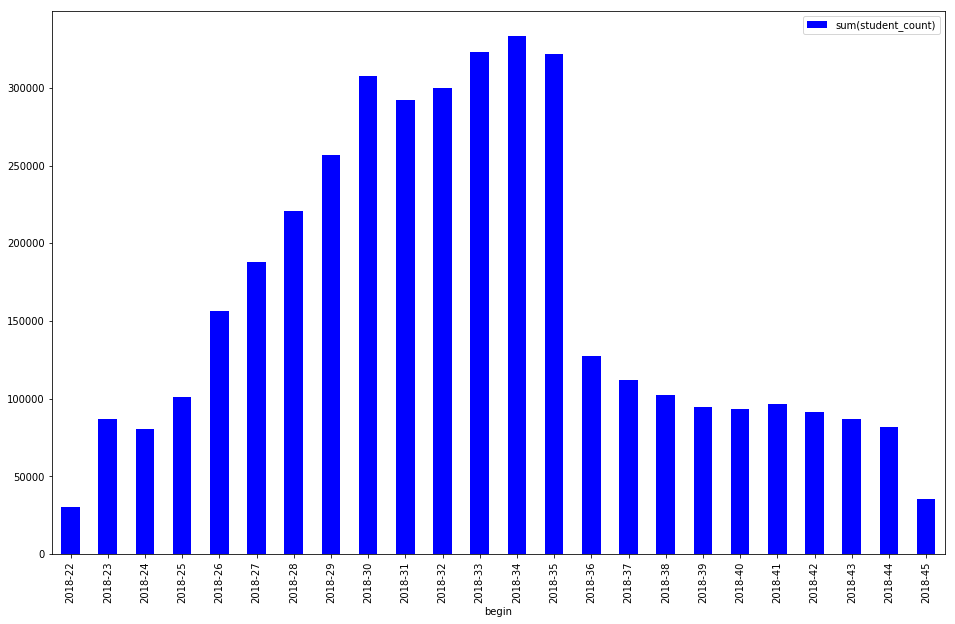

In [25]:
#f = plt.figure(1,figsize = [12,12])
df.plot(kind='bar',color='blue', figsize=(16,10))

In [7]:
if 0:
    with conn.cursor() as cur:
        sql = "select date_format(begin_at, '%Y-%m-%d') , sum(student_count) c  \
        from rooms r join schedules s on r.schedule_id = s.id and s.begin_at > '2018-06-01 00:00:00' \
        and s.begin_at <= '2018-09-01 00:00:00' \
        where status = 1 and r.is_internal = 0 group by date_format(begin_at, '%Y-%m-%d') having sum(student_count) > 100;"
        cur.execute(sql)
        raw_data = cur.fetchall()
    np_data_day = np.array(raw_data)
    inc_ts = pd.Series(np_data_day[:,1].astype(float), index = np_data_day[:,0])
    #ts.to_pickle('student_appointments_day.pkl')
else:
    ts = pd.read_pickle('student_appointments_day.pkl')

In [8]:
def draw_trend(timeSeries, size):
    f = plt.figure(3,figsize=(18,8),facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    #rol_weighted_mean = pd.ewma(timeSeries, span=size)
    rol_weighted_mean = timeSeries.ewm(span=size,min_periods=0,adjust=True,ignore_na=False).mean()

    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_acf_pacf(ts, lags=7):
    f = plt.figure(4,figsize=(20,20),facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

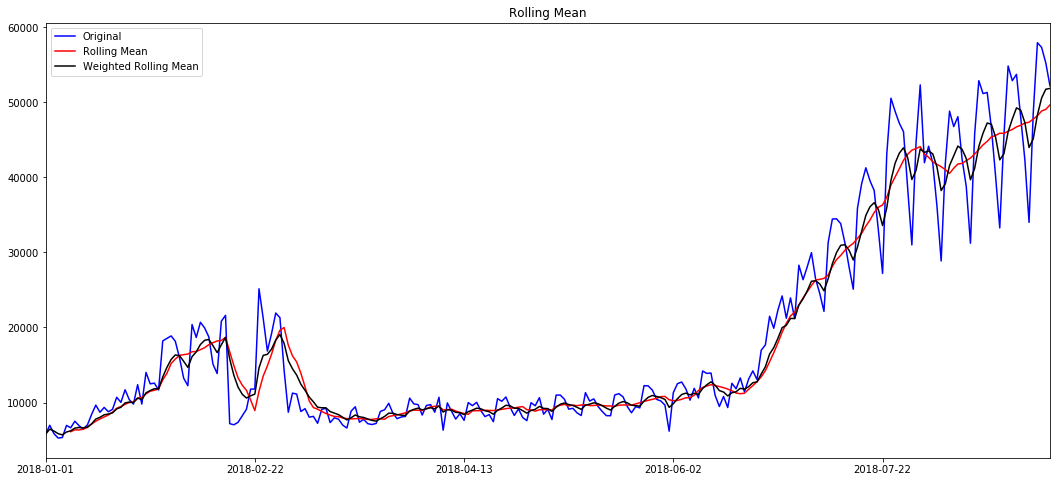

In [9]:
draw_trend(ts,7)

In [10]:
ts_sub = ts['2018-03-02':'2018-06-22']

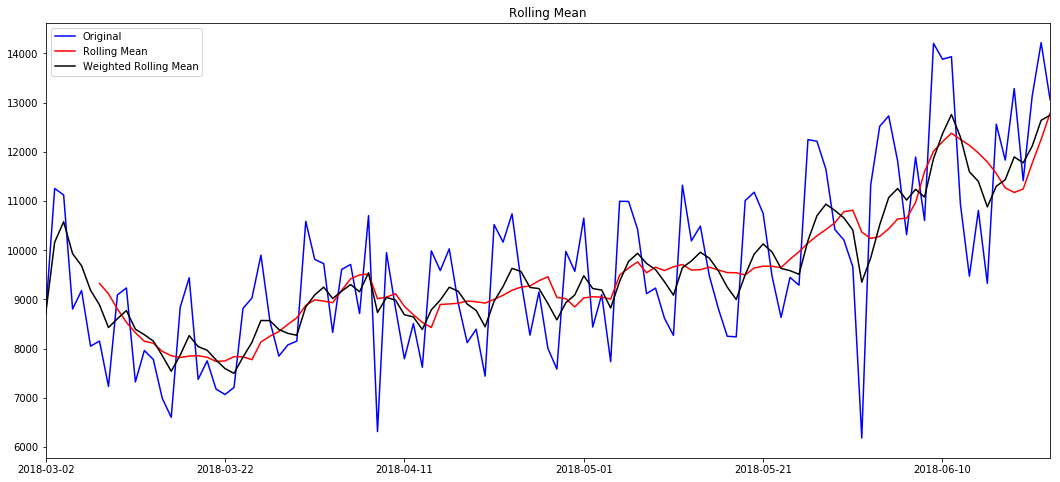

In [11]:
draw_trend(ts_sub, 7)

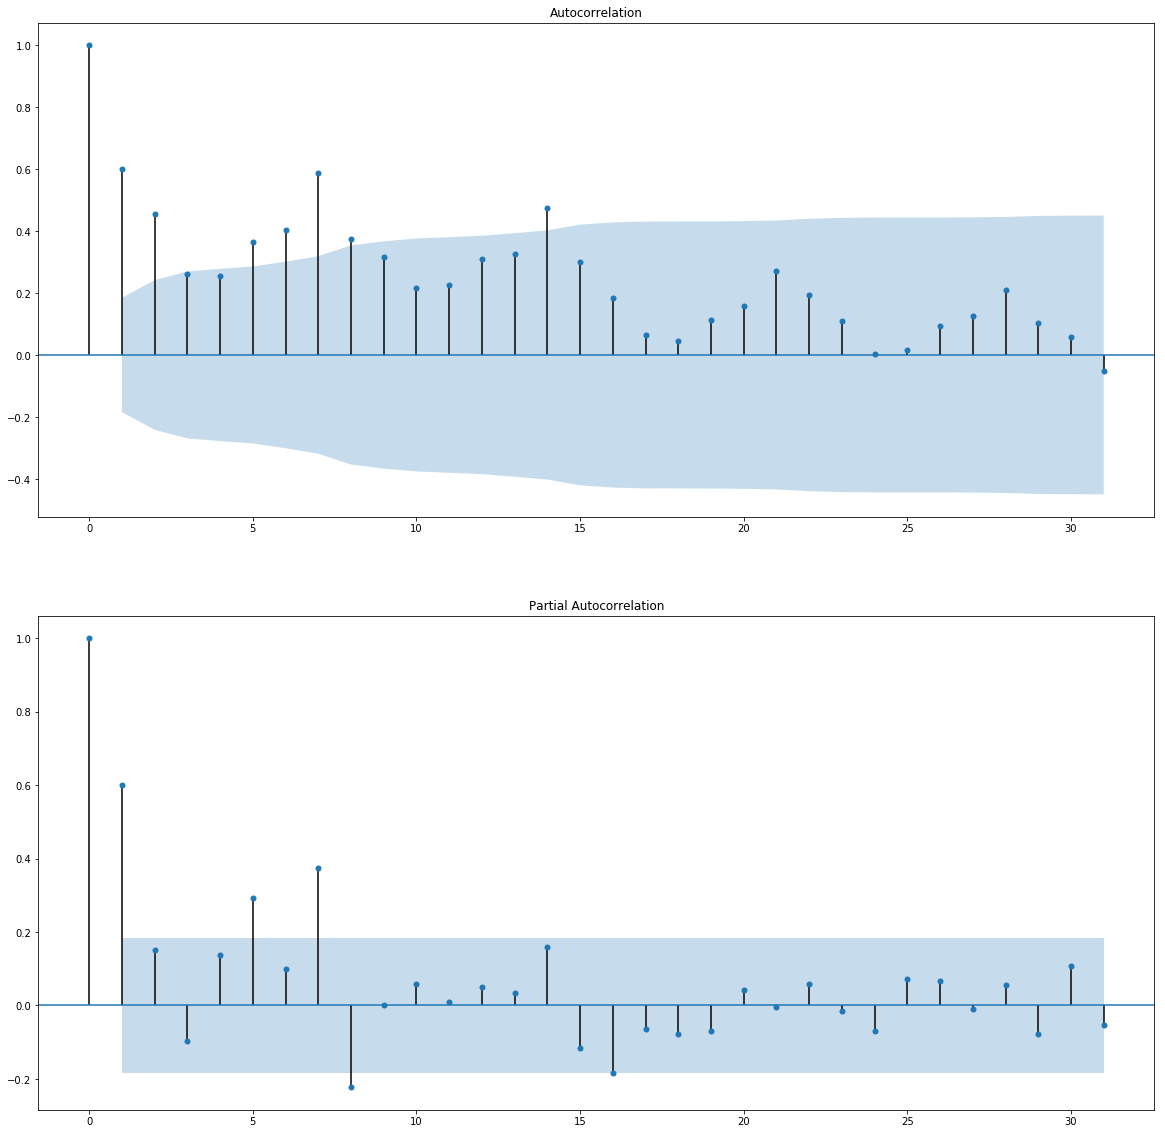

In [12]:
draw_acf_pacf(ts_sub, 7)

In [33]:
ts_diff = ts_sub.diff(7)
ts_sub.index = pd.to_datetime(ts_sub.index)

In [14]:
ts_diff.dropna(inplace=True)

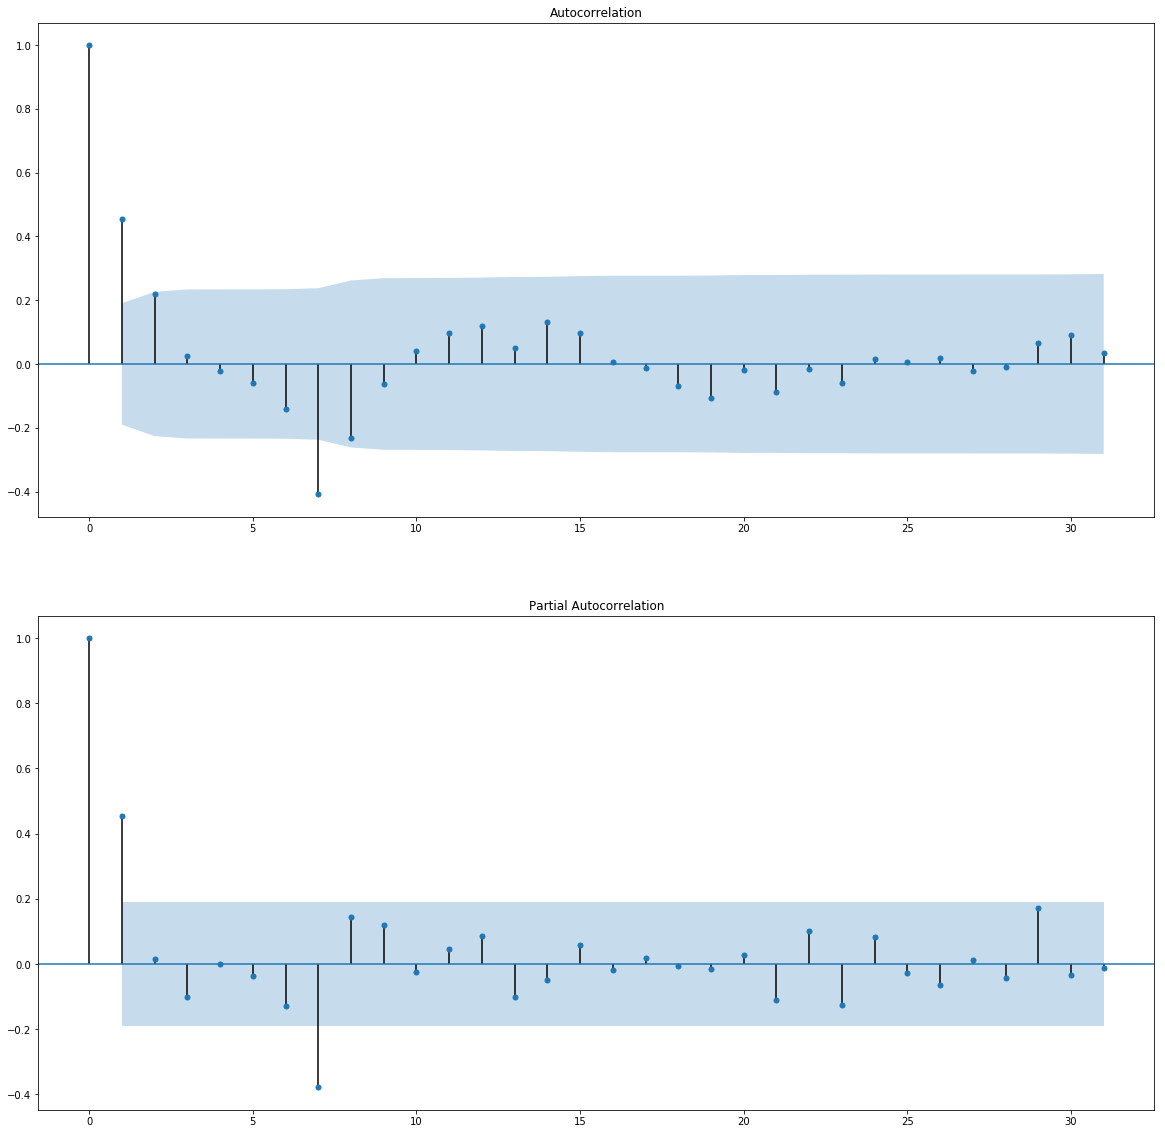

In [15]:
draw_acf_pacf(ts_diff, 7)

In [16]:
testStationarity(ts_diff)

Test Statistic                -6.307677e+00
p-value                        3.292836e-08
#Lags Used                     6.000000e+00
Number of Observations Used    9.900000e+01
Critical Value (1%)           -3.498198e+00
Critical Value (5%)           -2.891208e+00
Critical Value (10%)          -2.582596e+00
dtype: float64

In [17]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff, order=(2, 2)) 
result_arma = model.fit( disp=-1, method='css')
predict_ts = result_arma.predict()

In [30]:
pre_ts = predict_ts.add(ts_sub)

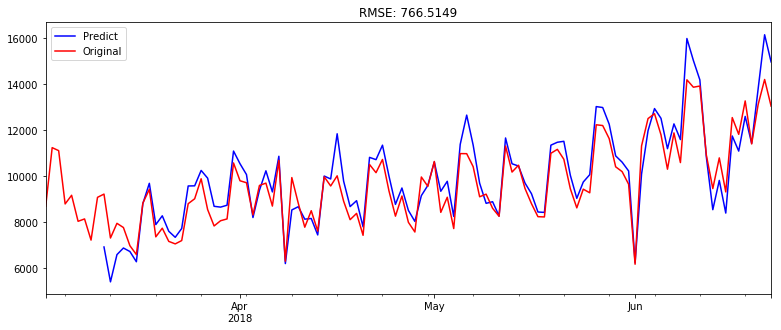

In [51]:
plt.figure(5,figsize= (13,5),facecolor='white')
pre_ts.plot(color='blue', label='Predict')
pre_ts_sub = pre_ts.dropna()
ts_sub.plot(color = 'red', label = 'Original')
ts_sub_sub = ts_sub['2018-03-11':]
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((pre_ts_sub-ts_sub_sub)**2)/ts_sub_sub.size))
plt.show()